In [1]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

In [2]:
#@title Install + Imports

import os, json, warnings, zipfile
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# imbalance tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import plotly.graph_objects as go
import plotly.express as px
from google.colab import files

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", 200)


In [5]:
#@title Import Dataset
from google.colab import drive
drive.mount('/content/drive')

# 🔁 Use the shared drive name and folder structure
SHARED_DRIVE = "CMPE_279_Anamoly_Detection"
PROJECT_DIR  = "Project"

# 🔧 Set main directory path
DRIVE_DIR = f"/content/drive/MyDrive/{SHARED_DRIVE}/{PROJECT_DIR}"

# 📂 Define dataset paths
RAW_CSV        = f"{DRIVE_DIR}/ACI-IoT-2023.csv"

DATA_DIR = "/content/preprocessed_iot"
OUT_DIR  = Path(DATA_DIR); OUT_DIR.mkdir(parents=True, exist_ok=True)

# ✅ Ensure folder exists
import os
os.makedirs(DRIVE_DIR, exist_ok=True)
print("Using folder:", DRIVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using folder: /content/drive/MyDrive/CMPE_279_Anamoly_Detection/Project


In [6]:
# Core column names
LABEL_COL = "Label"   # <-- change if needed

# Splits & reproducibility
TEST_SIZE     = 0.20
VAL_SIZE      = 0.20
RANDOM_STATE  = 42
TRAIN_BALANCE = "oversample"  # "oversample" | "undersample" | "none"
INPUT_CSV = RAW_CSV


In [8]:
# ==== TURBO MODE (fast & memory-safe) ====
FAST_MODE = True          # turn off later for full runs
ROW_CAP_TRAIN_PER_CLASS = 5000   # cap rows/class for TRAIN
ROW_CAP_VAL_TEST_PER_CLASS = 2000
MAX_CATS_PER_COL = 100    # bucket rare categories
DTYPE_FLOAT = "float32"   # reduce RAM vs float64

# FT-Transformer (lighter)
FTT_D_TOKEN        = 16   # was 32
FTT_N_BLOCKS       = 2    # was 3
FTT_N_HEADS        = 2    # was 4
FTT_MAX_EPOCHS     = 15   # was 40
FTT_PATIENCE       = 3    # was 6
FTT_BATCH_SIZE     = 512  # was 1024

# MLP (smaller)
MLP_HIDDEN1        = 256  # was 512
MLP_HIDDEN2        = 128  # was 256
MLP_DROPOUT        = 0.15
MLP_MAX_EPOCHS     = 20   # was 40
MLP_PATIENCE       = 5
MLP_BATCH_SIZE     = 512  # was 1024

# LightGBM (fewer trees)
LGBM_NUM_BOOST_ROUND  = 800   # was 5000
LGBM_EARLY_STOP_ROUND = 100

# General
NUM_WORKERS = 0  # keep 0 in Colab to avoid dataloader & fork overhead


In [10]:
#@title 🧹 Preprocess → split → balance → save (GPU-aware, fast & safe)

# ==== knobs ====
USE_GPU = True                 # 👈 turn on to scale numerics on GPU (if CUDA is available)
SKIP_PLOTS_IN_FAST = True      # skip plotly .show() when FAST_MODE to save time/memory

import gc
import torch

def clean_dataframe(df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found. Found: {df.columns.tolist()}")
    df = df.replace([np.inf, -np.inf], np.nan)
    nunique = df.nunique(dropna=False)
    drop_cols = nunique[nunique <= 1].index.tolist()
    if drop_cols:
        df = df.drop(columns=drop_cols)
    # fast NA fill
    for c in df.columns:
        if c == label_col:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].fillna(df[c].median())
        else:
            df[c] = df[c].astype(str).fillna("Unknown")
    return df

def detect_categoricals(df: pd.DataFrame, label_col: str, provided: Optional[List[str]]=None) -> List[str]:
    if provided:
        return [c for c in provided if c in df.columns and c != label_col]
    cats = []
    # object dtypes and small-cardinality ints → treated as categorical
    for c in df.columns:
        if c == label_col:
            continue
        if df[c].dtype == object:
            cats.append(c)
        else:
            if df[c].dtype.kind in "iu" and 2 <= df[c].nunique(dropna=True) <= 20:
                cats.append(c)
    return sorted(list(set(cats)))

def stratified_splits(df, label_col, test_size, val_size, seed):
    y = df[label_col]
    train_df, test_df = train_test_split(df, test_size=test_size, stratify=y, random_state=seed)
    y_tr = train_df[label_col]
    train_df, val_df = train_test_split(train_df, test_size=val_size, stratify=y_tr, random_state=seed)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

def balance_train(train_df: pd.DataFrame, label_col: str, strategy: str, seed: int) -> pd.DataFrame:
    if strategy not in {"oversample","undersample","none"}:
        strategy = "none"
    if strategy == "none":
        return train_df
    rng = np.random.default_rng(seed)
    groups = {k: g for k, g in train_df.groupby(label_col)}
    sizes  = {k: len(v) for k, v in groups.items()}
    if strategy == "oversample":
        target = max(sizes.values()); parts=[]
        for k,g in groups.items():
            if len(g) < target:
                idx = rng.choice(g.index.to_numpy(), size=target-len(g), replace=True)
                parts.append(pd.concat([g, train_df.loc[idx]], axis=0))
            else:
                parts.append(g)
        return pd.concat(parts).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    else:
        target = min(sizes.values())
        parts = [g.sample(n=target, random_state=seed) for g in groups.values()]
        return pd.concat(parts).sample(frac=1.0, random_state=seed).reset_index(drop=True)

def plot_class_bar(counts: pd.Series, title: str, out_html: Path):
    fig = go.Figure(go.Bar(x=counts.index.astype(str), y=counts.values))
    fig.update_layout(title=title, xaxis_title="Class", yaxis_title="Count", template="plotly_white")
    # avoid interactive render in FAST_MODE to reduce crashes
    if not (FAST_MODE and SKIP_PLOTS_IN_FAST):
        fig.show()
    fig.write_html(str(out_html), include_plotlyjs="cdn")

def plot_numeric_heatmap(df: pd.DataFrame, title: str, out_html: Path):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != LABEL_COL]
    if len(num_cols) < 2:
        return
    corr = df[num_cols].corr(method="spearman")
    fig = px.imshow(corr, color_continuous_scale="RdBu_r", origin="lower", title=title)
    fig.update_layout(template="plotly_white")
    if not (FAST_MODE and SKIP_PLOTS_IN_FAST):
        fig.show()
    fig.write_html(str(out_html), include_plotlyjs="cdn")

# 1) Load & clean
df = pd.read_csv(INPUT_CSV)
df = clean_dataframe(df, LABEL_COL)

# 2) Detect cats/nums
cat_cols = detect_categoricals(df, LABEL_COL, provided=None)
num_cols = [c for c in df.columns if c not in cat_cols + [LABEL_COL]]

# Downcast numerics to float32 / int32 to save RAM
for c in df.columns:
    if c == LABEL_COL:
        continue
    if pd.api.types.is_float_dtype(df[c]):
        df[c] = df[c].astype(DTYPE_FLOAT)
    elif pd.api.types.is_integer_dtype(df[c]):
        if df[c].min() >= np.iinfo(np.int32).min and df[c].max() <= np.iinfo(np.int32).max:
            df[c] = df[c].astype("int32")

# Bucket rare categories to keep one-hot small
def bucket_rare_cats(frame, cols, max_cats=MAX_CATS_PER_COL):
    for c in cols:
        if c not in frame.columns:
            continue
        vc = frame[c].value_counts(sort=True, dropna=False)
        if len(vc) > max_cats:
            keep = set(vc.head(max_cats).index)
            frame[c] = frame[c].where(frame[c].isin(keep), other="__OTHER__")
    return frame

df[cat_cols] = df[cat_cols].astype(str)
if FAST_MODE:
    df = bucket_rare_cats(df, cat_cols, MAX_CATS_PER_COL)

# 3) Split
train_df, val_df, test_df = stratified_splits(df, LABEL_COL, TEST_SIZE, VAL_SIZE, RANDOM_STATE)

# Stratified caps per class to reduce size safely (for fast runs)
def strat_cap_per_class(frame, per_class, label_col):
    parts = []
    for y, g in frame.groupby(label_col):
        if len(g) > per_class:
            parts.append(g.sample(per_class, random_state=RANDOM_STATE))
        else:
            parts.append(g)
    out = pd.concat(parts).sample(frac=1.0, random_state=RANDOM_STATE)
    return out

if FAST_MODE:
    train_df = strat_cap_per_class(train_df, ROW_CAP_TRAIN_PER_CLASS, LABEL_COL)
    val_df   = strat_cap_per_class(val_df, ROW_CAP_VAL_TEST_PER_CLASS, LABEL_COL)
    test_df  = strat_cap_per_class(test_df, ROW_CAP_VAL_TEST_PER_CLASS, LABEL_COL)

# 4) Plots (before/after balance)
plot_class_bar(train_df[LABEL_COL].value_counts().sort_index(),
               "Train Class Distribution (Before Balance)", OUT_DIR/"train_before.html")
train_bal = balance_train(train_df, LABEL_COL, TRAIN_BALANCE, RANDOM_STATE)
plot_class_bar(train_bal[LABEL_COL].value_counts().sort_index(),
               "Train Class Distribution (After Balance)", OUT_DIR/"train_after.html")

# 5) optional numeric heatmaps
plot_numeric_heatmap(train_df, "Spearman Correlation — Train (Before Balance)", OUT_DIR/"corr_before.html")
plot_numeric_heatmap(train_bal, "Spearman Correlation — Train (After Balance)", OUT_DIR/"corr_after.html")

# 6) Scale numerics (GPU if available & requested)
def scale_on_gpu(train_df, val_df, test_df, num_cols):
    """Standardize numeric columns using torch on CUDA, then return CPU DataFrames."""
    if not num_cols:
        return train_df, val_df, test_df, None
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type != "cuda":
        return scale_on_cpu(train_df, val_df, test_df, num_cols)  # fallback

    # to GPU
    t_train = torch.tensor(train_df[num_cols].to_numpy(), dtype=torch.float32, device=device)
    mean = t_train.mean(dim=0, keepdim=True)
    std  = t_train.std(dim=0, unbiased=False, keepdim=True).clamp_min(1e-8)

    def _transform(df_part):
        t = torch.tensor(df_part[num_cols].to_numpy(), dtype=torch.float32, device=device)
        t = (t - mean) / std
        return pd.DataFrame(t.cpu().numpy().astype("float32"), columns=num_cols, index=df_part.index)

    # transform and assign back (in-place assignment avoids large copies)
    train_scaled = _transform(train_df)
    val_scaled   = _transform(val_df)
    test_scaled  = _transform(test_df)

    for c in num_cols:
        train_df[c] = train_scaled[c].astype(DTYPE_FLOAT)
        val_df[c]   = val_scaled[c].astype(DTYPE_FLOAT)
        test_df[c]  = test_scaled[c].astype(DTYPE_FLOAT)

    # save stats for later reuse (mimic sklearn StandardScaler)
    scaler_state = {"mean_": mean.squeeze(0).cpu().numpy(), "scale_": std.squeeze(0).cpu().numpy(), "num_cols": num_cols}
    return train_df, val_df, test_df, scaler_state

def scale_on_cpu(train_df, val_df, test_df, num_cols):
    if not num_cols:
        return train_df, val_df, test_df, None
    scaler = StandardScaler()
    scaler.fit(train_df[num_cols])
    train_df[num_cols] = scaler.transform(train_df[num_cols]).astype(DTYPE_FLOAT)
    val_df[num_cols]   = scaler.transform(val_df[num_cols]).astype(DTYPE_FLOAT)
    test_df[num_cols]  = scaler.transform(test_df[num_cols]).astype(DTYPE_FLOAT)
    return train_df, val_df, test_df, {"sklearn": True, "scaler": scaler, "num_cols": num_cols}

if USE_GPU and torch.cuda.is_available():
    train_bal, val_df, test_df, scaler_bundle_state = scale_on_gpu(train_bal, val_df, test_df, num_cols)
else:
    train_bal, val_df, test_df, scaler_bundle_state = scale_on_cpu(train_bal, val_df, test_df, num_cols)

# 7) Ensure categoricals are strings
for c in cat_cols + [LABEL_COL]:
    for split in (train_bal, val_df, test_df):
        if c in split.columns:
            split[c] = split[c].astype(str)

# 8) Save canonical splits for tabular DL/MLP
train_bal.to_csv(OUT_DIR/"ftt_train.csv", index=False)
val_df.to_csv(OUT_DIR/"ftt_val.csv", index=False)
test_df.to_csv(OUT_DIR/"ftt_test.csv", index=False)

# build a unified scaler bundle (works for GPU or CPU path)
if scaler_bundle_state and scaler_bundle_state.get("sklearn"):
    # sklearn scaler object
    joblib.dump({"num_cols": num_cols, "cat_cols": cat_cols, "scaler": scaler_bundle_state["scaler"]}, OUT_DIR/"ftt_scaler.joblib")
else:
    # torch-computed mean/std; keep simple dict (you can load and use manually later)
    joblib.dump({"num_cols": num_cols, "cat_cols": cat_cols, "mean_": (scaler_bundle_state or {}).get("mean_"),
                 "scale_": (scaler_bundle_state or {}).get("scale_"), "scaler": None}, OUT_DIR/"ftt_scaler.joblib")

# 9) Label mapping (for reports)
cats = pd.Categorical(df[LABEL_COL])
label_map = {str(cat): int(code) for code, cat in enumerate(cats.categories)}
(OUT_DIR/"label_mapping.json").write_text(json.dumps(label_map, indent=2))

# Free memory
del df; gc.collect()

print("Saved to:", OUT_DIR)
print("Categoricals:", cat_cols[:10], "… total", len(cat_cols))
print("Numerics:", num_cols[:10], "… total", len(num_cols))
print("Scaling:", "GPU (torch)" if (USE_GPU and torch.cuda.is_available()) else "CPU (sklearn)")


Saved to: /content/preprocessed_iot
Categoricals: ['CWR Flag Count', 'Connection Type', 'Dst IP', 'ECE Flag Count', 'FIN Flag Count', 'Flow ID', 'Fwd PSH Flags', 'Fwd Seg Size Min', 'Fwd URG Flags', 'Protocol'] … total 16
Numerics: ['Src Port', 'Dst Port', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean'] … total 62
Scaling: GPU (torch)


Epoch 00 | train loss 0.9026 f1 0.7414 | val loss 0.2849 f1 0.8440
Epoch 01 | train loss 0.2197 f1 0.9332 | val loss 0.1463 f1 0.9228
Epoch 02 | train loss 0.1379 f1 0.9591 | val loss 0.1112 f1 0.9373
Epoch 03 | train loss 0.1063 f1 0.9689 | val loss 0.0922 f1 0.9465
Epoch 04 | train loss 0.0877 f1 0.9751 | val loss 0.0840 f1 0.9550
Epoch 05 | train loss 0.0753 f1 0.9789 | val loss 0.0750 f1 0.9632
Epoch 06 | train loss 0.0649 f1 0.9820 | val loss 0.0644 f1 0.9694
Epoch 07 | train loss 0.0587 f1 0.9838 | val loss 0.0563 f1 0.9727
Epoch 08 | train loss 0.0520 f1 0.9867 | val loss 0.0493 f1 0.9798
Epoch 09 | train loss 0.0476 f1 0.9882 | val loss 0.0536 f1 0.9747
Epoch 10 | train loss 0.0428 f1 0.9896 | val loss 0.0419 f1 0.9778
Epoch 11 | train loss 0.0401 f1 0.9908 | val loss 0.0381 f1 0.9783
Epoch 12 | train loss 0.0371 f1 0.9915 | val loss 0.0366 f1 0.9815
Epoch 13 | train loss 0.0348 f1 0.9922 | val loss 0.0378 f1 0.9760
Epoch 14 | train loss 0.0341 f1 0.9919 | val loss 0.0357 f1 0.

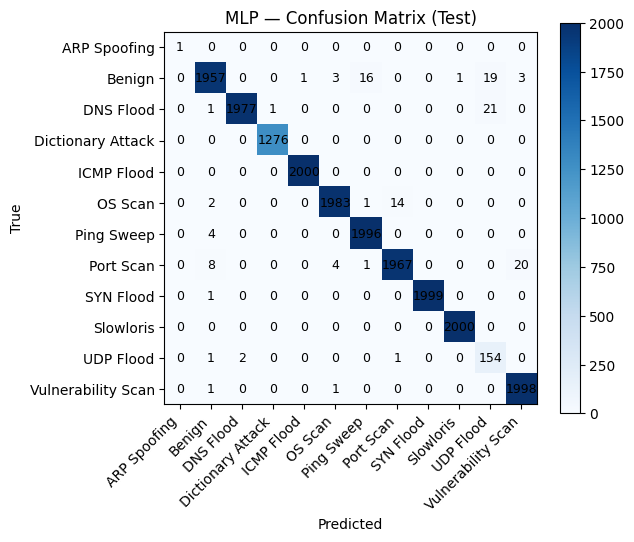

In [11]:
#@title 🧠 MLP — one-hot cats + scaled nums
import torch
import torch.nn as nn
import torch.optim as optim

# metrics & plots
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path # Import Path for OUT_DIR

# Define OUT_DIR as it might not be in the current kernel state
DATA_DIR = "/content/preprocessed_iot"
OUT_DIR  = Path(DATA_DIR)

train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")

bundle = joblib.load(OUT_DIR/"ftt_scaler.joblib")
CAT_COLS = bundle["cat_cols"] or []
NUM_COLS = bundle["num_cols"] or []

# One-hot encoder (fit on TRAIN only)
ohe = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CAT_COLS),
    ("pass", "passthrough", NUM_COLS),
])

Xtr = ohe.fit_transform(train[CAT_COLS+NUM_COLS])
Xva = ohe.transform(val[CAT_COLS+NUM_COLS])
Xte = ohe.transform(test[CAT_COLS+NUM_COLS])

classes = sorted(train[LABEL_COL].unique().tolist())
lab2id = {c:i for i,c in enumerate(classes)}
ytr = train[LABEL_COL].map(lab2id).to_numpy()
yva = val[LABEL_COL].map(lab2id).to_numpy()
yte = test[LABEL_COL].map(lab2id).to_numpy()

# Torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)
Xte_t = torch.tensor(Xte, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.long, device=device)
yva_t = torch.tensor(yva, dtype=torch.long, device=device)
yte_t = torch.tensor(yte, dtype=torch.long, device=device)

class NPDataset(torch.utils.data.Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

bs = 1024
tr_loader = torch.utils.data.DataLoader(NPDataset(Xtr_t, ytr_t), batch_size=bs, shuffle=True)
va_loader = torch.utils.data.DataLoader(NPDataset(Xva_t, yva_t), batch_size=bs, shuffle=False)
te_loader = torch.utils.data.DataLoader(NPDataset(Xte_t, yte_t), batch_size=bs, shuffle=False)

# MLP
in_dim, n_class = Xtr_t.shape[1], len(classes)
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden=512, d_hidden2=256, n_out=2, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), nn.ReLU(), nn.Dropout(p),
            nn.Linear(d_hidden, d_hidden2), nn.ReLU(), nn.Dropout(p),
            nn.Linear(d_hidden2, n_out)
        )
    def forward(self, x): return self.net(x)

mlp = MLP(in_dim, 512, 256, n_class, 0.2).to(device)
opt = optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

def run_epoch(model, loader, train=True):
    model.train() if train else model.eval()
    total_loss, preds, gts = 0.0, [], []
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            if train: opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            if train:
                loss.backward(); opt.step()
            total_loss += float(loss.item())*len(xb)
            preds.append(logits.detach().argmax(1).cpu().numpy())
            gts.append(yb.detach().cpu().numpy())
    y_hat = np.concatenate(preds); y_true = np.concatenate(gts)
    return total_loss/len(loader.dataset), accuracy_score(y_true,y_hat), f1_score(y_true,y_hat,average="macro")

best_f1, patience, wait = -1, 8, 0
for epoch in range(40):
    tr_loss, tr_acc, tr_f1 = run_epoch(mlp, tr_loader, train=True)
    va_loss, va_acc, va_f1 = run_epoch(mlp, va_loader, train=False)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} f1 {tr_f1:.4f} | val loss {va_loss:.4f} f1 {va_f1:.4f}")
    if va_f1 > best_f1:
        best_f1, wait = va_f1, 0
        torch.save(mlp.state_dict(), "/content/mlp_best.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping."); break

mlp.load_state_dict(torch.load("/content/mlp_best.pt", map_location=device))

# Test
mlp.eval()
preds, gts = [], []
with torch.no_grad():
    for xb, yb in te_loader:
        logits = mlp(xb); preds.append(logits.argmax(1).cpu().numpy()); gts.append(yb.cpu().numpy())
y_hat = np.concatenate(preds); y_true = np.concatenate(gts)

print(f"[MLP] Test Acc: {accuracy_score(y_true,y_hat):.4f} | Macro-F1: {f1_score(y_true,y_hat,average='macro'):.4f}")
print(classification_report(y_true, y_hat, target_names=classes, zero_division=0))

cm = confusion_matrix(y_true, y_hat)
plt.figure(figsize=(6.5,5.5))
plt.imshow(cm, cmap="Blues"); plt.title("MLP — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j,i,cm[i,j], ha="center", va="center", fontsize=9)
plt.tight_layout(); plt.show()

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.000902071	train's multi_error: 0.000116667	val's multi_logloss: 0.00255272	val's multi_error: 0.000417776
[200]	train's multi_logloss: 0.00011899	train's multi_error: 0	val's multi_logloss: 0.00170256	val's multi_error: 0.000417776
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.000302247	train's multi_error: 0	val's multi_logloss: 0.00192959	val's multi_error: 0.000365554
Training finished in 38.5s. Best iteration: 137
[LGBM] Test Acc: 0.9995 | Macro-F1: 0.9989
                    precision    recall  f1-score   support

      ARP Spoofing       1.00      1.00      1.00         1
            Benign       1.00      1.00      1.00      2000
         DNS Flood       1.00      1.00      1.00      2000
 Dictionary Attack       1.00      1.00      1.00      1276
        ICMP Flood       1.00      1.00      1.00      2000
           OS Scan       1.00      1.00      1.00      2000
 

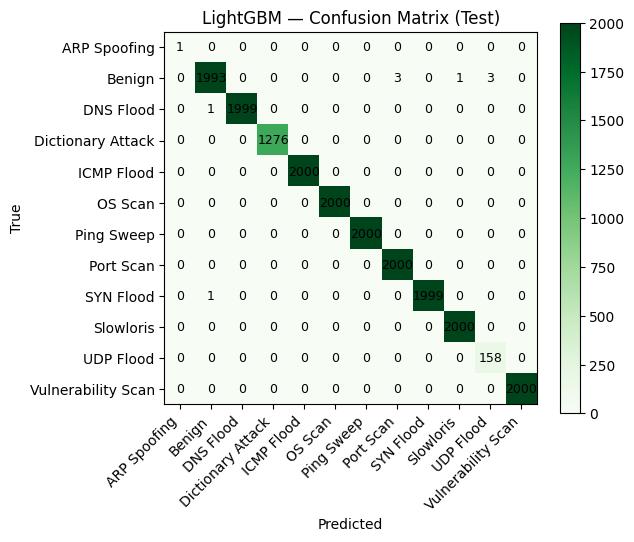

Saved: /content/lgbm_model.txt /content/ohe.joblib /content/classes.json


In [15]:
#@title 🌳 LightGBM — modern API (early stopping via callbacks)
import json, time, gc
import numpy as np, pandas as pd, joblib, lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ---------- Load canonical splits ----------
train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")

bundle = joblib.load(OUT_DIR/"ftt_scaler.joblib")
CAT_COLS = bundle["cat_cols"] or []
NUM_COLS = bundle["num_cols"] or []

classes = sorted(train[LABEL_COL].unique().tolist())
lab2id  = {c:i for i,c in enumerate(classes)}
id2lab  = {i:c for c,i in lab2id.items()}

ytr = train[LABEL_COL].map(lab2id).to_numpy()
yva = val[LABEL_COL].map(lab2id).to_numpy()
yte = test[LABEL_COL].map(lab2id).to_numpy()

# ---------- OneHotEncoder (handles both new & old sklearn) ----------
try:
    ohe = ColumnTransformer([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32), CAT_COLS),
        ("pass", "passthrough", NUM_COLS),
    ])
except TypeError:
    ohe = ColumnTransformer([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32), CAT_COLS),
        ("pass", "passthrough", NUM_COLS),
    ])

Xtr = ohe.fit_transform(train[CAT_COLS+NUM_COLS])
Xva = ohe.transform(val[CAT_COLS+NUM_COLS])
Xte = ohe.transform(test[CAT_COLS+NUM_COLS])
del train, val, test; gc.collect()

# ---------- Datasets ----------
lgb_tr = lgb.Dataset(Xtr, label=ytr)
lgb_va = lgb.Dataset(Xva, label=yva, reference=lgb_tr)

# ---------- Parameters ----------
num_classes = len(classes)
params = dict(
    objective="multiclass",
    num_class=num_classes,
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=48,
    max_depth=-1,
    min_data_in_leaf=64,
    feature_fraction=0.85,
    bagging_fraction=0.85,
    bagging_freq=1,
    lambda_l2=1.0,
    metric=["multi_logloss", "multi_error"],
    seed=RANDOM_STATE,
    verbosity=-1,
    n_jobs=-1,
)

# ---------- Training (callback API) ----------
t0 = time.perf_counter()
callbacks = [
    lgb.early_stopping(stopping_rounds=100, verbose=True),
    lgb.log_evaluation(period=100),
]

lgbm = lgb.train(
    params=params,
    train_set=lgb_tr,
    valid_sets=[lgb_tr, lgb_va],
    valid_names=["train","val"],
    num_boost_round=1200,
    callbacks=callbacks,
)
t1 = time.perf_counter()
print(f"Training finished in {(t1 - t0):.1f}s. Best iteration: {lgbm.best_iteration}")

# ---------- Evaluation ----------
proba = lgbm.predict(Xte, num_iteration=lgbm.best_iteration)
y_pred = proba.argmax(1)
print(f"[LGBM] Test Acc: {accuracy_score(yte,y_pred):.4f} | Macro-F1: {f1_score(yte,y_pred,average='macro'):.4f}")
print(classification_report(yte, y_pred, target_names=classes, zero_division=0))

import matplotlib.pyplot as plt
cm = confusion_matrix(yte, y_pred)
plt.figure(figsize=(6.5,5.5))
plt.imshow(cm, cmap="Greens"); plt.title("LightGBM — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j,i,cm[i,j], ha="center", va="center", fontsize=9)
plt.tight_layout(); plt.show()

# ---------- Save artifacts ----------
MODEL_TXT   = "/content/lgbm_model.txt"
OHE_PATH    = "/content/ohe.joblib"
CLASSES_JSON= "/content/classes.json"

lgbm.save_model(MODEL_TXT, num_iteration=lgbm.best_iteration)
joblib.dump(ohe, OHE_PATH)
with open(CLASSES_JSON, "w") as f:
    json.dump(classes, f)

print("Saved:", MODEL_TXT, OHE_PATH, CLASSES_JSON)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



Epoch 00 | train loss 1.5022 f1 0.5447 | val loss 0.8342 f1 0.6783
Epoch 01 | train loss 0.5221 f1 0.9018 | val loss 0.2160 f1 0.8829
Epoch 02 | train loss 0.1951 f1 0.9665 | val loss 0.1124 f1 0.8935
Epoch 03 | train loss 0.1062 f1 0.9801 | val loss 0.0588 f1 0.9411
Epoch 04 | train loss 0.0723 f1 0.9848 | val loss 0.0465 f1 0.9495
Epoch 05 | train loss 0.0581 f1 0.9868 | val loss 0.0389 f1 0.9799
Epoch 06 | train loss 0.0503 f1 0.9886 | val loss 0.0396 f1 0.9508
Epoch 07 | train loss 0.0463 f1 0.9889 | val loss 0.0375 f1 0.9747
Epoch 08 | train loss 0.0435 f1 0.9896 | val loss 0.0497 f1 0.9448
Epoch 09 | train loss 0.0394 f1 0.9902 | val loss 0.0397 f1 0.9500
Epoch 10 | train loss 0.0363 f1 0.9912 | val loss 0.0324 f1 0.9540
Epoch 11 | train loss 0.0341 f1 0.9914 | val loss 0.0396 f1 0.9336
Epoch 12 | train loss 0.0316 f1 0.9922 | val loss 0.0324 f1 0.9344
Epoch 13 | train loss 0.0317 f1 0.9920 | val loss 0.0301 f1 0.9838
Epoch 14 | train loss 0.0281 f1 0.9929 | val loss 0.0297 f1 0.

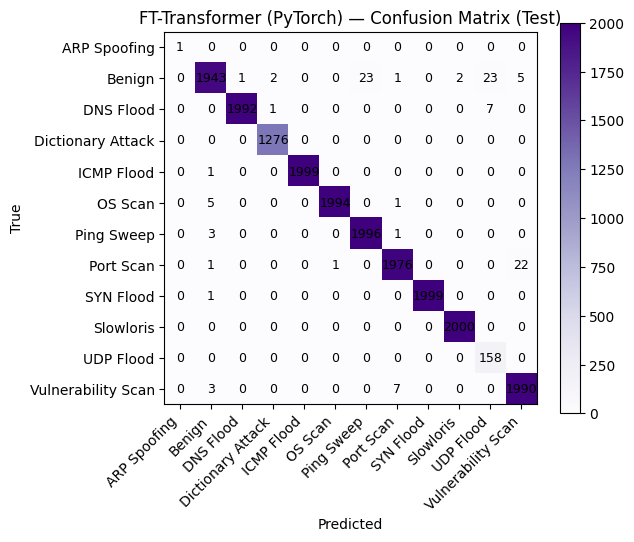

Saved artifacts to: /content/ftt_pure_artifacts


In [19]:
# @title 🤖 FT-Transformer (Pure PyTorch) — fast & dependency-free
import os, json, gc, time, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Turbo knobs (safe defaults) ====
D_TOKEN     = 16
N_HEADS     = 2
N_BLOCKS    = 2
FF_MULT     = 4
DROPOUT     = 0.10
BATCH_SIZE  = 512
MAX_EPOCHS  = 15
PATIENCE    = 3
LR          = 1e-3
WEIGHT_DECAY= 1e-4
SEED        = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# ---- Load splits & meta ----
train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")

scaler_bundle = joblib.load(OUT_DIR/"ftt_scaler.joblib")
CAT_COLS = scaler_bundle.get("cat_cols", []) or []
NUM_COLS = scaler_bundle.get("num_cols", []) or []
LABEL_COL = "Label"  # change if you used a different name

# Make sure types are consistent
for c in CAT_COLS + [LABEL_COL]:
    for df_ in (train, val, test):
        if c in df_.columns:
            df_[c] = df_[c].astype(str)

classes = sorted(train[LABEL_COL].unique().tolist())
n_classes = len(classes)
lab2id = {c:i for i,c in enumerate(classes)}

y_tr = train[LABEL_COL].map(lab2id).to_numpy()
y_va = val[LABEL_COL].map(lab2id).to_numpy()
y_te = test[LABEL_COL].map(lab2id).to_numpy()

# ---- Build per-column categorical encoders (ordinal) ----
# Unknowns map to index 0; real categories start at 1
cat_maps = []
cat_cardinalities = []
for c in CAT_COLS:
    uniq = pd.Index(train[c].unique().tolist())
    mapping = {v: i+1 for i, v in enumerate(uniq)}  # 1..K
    cat_maps.append(mapping)
    cat_cardinalities.append(len(mapping) + 1)      # +1 for unknown 0

def cats_to_idx(frame: pd.DataFrame) -> np.ndarray:
    if not CAT_COLS:
        return np.zeros((len(frame), 0), dtype=np.int64)
    mats = []
    for (c, mapping) in zip(CAT_COLS, cat_maps):
        idx = frame[c].map(mapping).fillna(0).astype(np.int64).to_numpy()
        mats.append(idx.reshape(-1,1))
    return np.concatenate(mats, axis=1)

def nums_to_float(frame: pd.DataFrame) -> np.ndarray:
    if not NUM_COLS:
        return np.zeros((len(frame), 0), dtype=np.float32)
    return frame[NUM_COLS].to_numpy(dtype=np.float32)

Xtr_num = nums_to_float(train)
Xva_num = nums_to_float(val)
Xte_num = nums_to_float(test)

Xtr_cat = cats_to_idx(train)
Xva_cat = cats_to_idx(val)
Xte_cat = cats_to_idx(test)

# ---- Torch Datasets & Loaders ----
class TabDataset(torch.utils.data.Dataset):
    def __init__(self, X_num, X_cat, y):
        self.Xn = torch.tensor(X_num, dtype=torch.float32)
        self.Xc = torch.tensor(X_cat, dtype=torch.long)
        self.y  = torch.tensor(y, dtype=torch.long)
    def __len__(self): return self.Xn.shape[0]
    def __getitem__(self, i): return self.Xn[i], self.Xc[i], self.y[i]

tr_ds = TabDataset(Xtr_num, Xtr_cat, y_tr)
va_ds = TabDataset(Xva_num, Xva_cat, y_va)
te_ds = TabDataset(Xte_num, Xte_cat, y_te)

tr_loader = torch.utils.data.DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=(DEVICE.type=="cuda"))
va_loader = torch.utils.data.DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(DEVICE.type=="cuda"))
te_loader = torch.utils.data.DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(DEVICE.type=="cuda"))

# ---- FT-Transformer-ish model (feature-tokenizer + encoder + CLS head) ----
class FTTransformer(nn.Module):
    def __init__(self, n_num, cat_cardinalities, d_token=32, n_heads=4, n_blocks=3, ff_mult=4, dropout=0.1, n_classes=2):
        super().__init__()
        self.n_num = n_num
        self.n_cat = len(cat_cardinalities)
        self.d = d_token

        # CLS token
        self.cls = nn.Parameter(torch.zeros(1, 1, d_token))

        # Numeric tokens: per-feature scale+bias to d_token (fast & memory-light)
        if n_num > 0:
            self.num_weight = nn.Parameter(torch.randn(n_num, d_token) * 0.02)
            self.num_bias   = nn.Parameter(torch.zeros(n_num, d_token))
        else:
            self.register_parameter("num_weight", None)
            self.register_parameter("num_bias", None)

        # Categorical tokens: one embedding per column
        self.embeddings = nn.ModuleList([
            nn.Embedding(card, d_token) for card in cat_cardinalities
        ])

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=d_token * ff_mult,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,  # prenorm
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_blocks)

        # Head on CLS
        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, n_classes)
        )

    def forward(self, x_num, x_cat):
        B = x_num.shape[0]
        tokens = []

        # CLS
        cls_tok = self.cls.expand(B, -1, -1)  # [B,1,d]
        tokens.append(cls_tok)

        # Numeric feature tokens
        if self.n_num > 0:
            # x_num: [B, n_num] → [B, n_num, d]
            num_tok = x_num.unsqueeze(-1) * self.num_weight + self.num_bias
            tokens.append(num_tok)

        # Categorical feature tokens
        for i, emb in enumerate(self.embeddings):
            tok = emb(x_cat[:, i])  # [B, d]
            tokens.append(tok.unsqueeze(1))

        x = torch.cat(tokens, dim=1)  # [B, 1+n_num+n_cat, d]
        x = self.encoder(x)           # transformer
        cls = x[:, 0, :]              # CLS
        logits = self.head(cls)
        return logits

model = FTTransformer(
    n_num=Xtr_num.shape[1],
    cat_cardinalities=cat_cardinalities,
    d_token=D_TOKEN,
    n_heads=N_HEADS,
    n_blocks=N_BLOCKS,
    ff_mult=FF_MULT,
    dropout=DROPOUT,
    n_classes=n_classes,
).to(DEVICE)

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit = nn.CrossEntropyLoss()

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total, preds, gts = 0.0, [], []
    for xb_num, xb_cat, yb in loader:
        xb_num, xb_cat, yb = xb_num.to(DEVICE), xb_cat.to(DEVICE), yb.to(DEVICE)
        if train: opt.zero_grad(set_to_none=True)
        logits = model(xb_num, xb_cat)
        loss = crit(logits, yb)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total += loss.item() * yb.size(0)
        preds.append(logits.detach().argmax(1).cpu().numpy())
        gts.append(yb.detach().cpu().numpy())
    y_hat = np.concatenate(preds); y_true = np.concatenate(gts)
    return total/len(loader.dataset), accuracy_score(y_true,y_hat), f1_score(y_true,y_hat,average="macro")

best_val, wait = float("inf"), 0
for epoch in range(MAX_EPOCHS):
    tr_loss, tr_acc, tr_f1 = run_epoch(tr_loader, train=True)
    va_loss, va_acc, va_f1 = run_epoch(va_loader, train=False)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} f1 {tr_f1:.4f} | val loss {va_loss:.4f} f1 {va_f1:.4f}")
    if va_loss < best_val - 1e-4:
        best_val, wait = va_loss, 0
        torch.save(model.state_dict(), "/content/ftt_pure_best.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break

model.load_state_dict(torch.load("/content/ftt_pure_best.pt", map_location=DEVICE))

# ---- Test ----
model.eval()
preds, gts = [], []
with torch.no_grad():
    for xb_num, xb_cat, yb in te_loader:
        xb_num, xb_cat = xb_num.to(DEVICE), xb_cat.to(DEVICE)
        logits = model(xb_num, xb_cat)
        preds.append(logits.argmax(1).cpu().numpy())
        gts.append(yb.numpy())
y_pred = np.concatenate(preds); y_true = np.concatenate(gts)
print(f"[FTT-PyTorch] Test Acc: {accuracy_score(y_true,y_pred):.4f} | Macro-F1: {f1_score(y_true,y_pred,average='macro'):.4f}")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

# Confusion Matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6.5,5.5))
plt.imshow(cm, cmap="Purples"); plt.title("FT-Transformer (PyTorch) — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j,i,cm[i,j], ha="center", va="center", fontsize=9)
plt.tight_layout(); plt.show()

# ---- Save artifacts for Streamlit ----
ART_DIR = Path("/content/ftt_pure_artifacts"); ART_DIR.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), ART_DIR/"model.pt")
meta = {
    "label_col": LABEL_COL,
    "classes": classes,
    "cat_cols": CAT_COLS,
    "num_cols": NUM_COLS,
    "cat_maps": [{k:str(v) for k,v in m.items()} for m in cat_maps],  # keys are strings; unknown -> 0
    "cat_cardinalities": cat_cardinalities,
    "model_hparams": {
        "d_token": D_TOKEN, "n_heads": N_HEADS, "n_blocks": N_BLOCKS,
        "ff_mult": FF_MULT, "dropout": DROPOUT, "n_classes": n_classes
    }
}
(ART_DIR/"meta.json").write_text(json.dumps(meta, indent=2))
# also copy scaler bundle for inference
joblib.dump(scaler_bundle, ART_DIR/"ftt_scaler.joblib")

print("Saved artifacts to:", ART_DIR)
